# Load Dataset


In [1]:
from datasets import load_dataset

filename = "../data/news-docs.2020.processed.csv"
dataset = load_dataset('csv', data_files=filename, column_names=["date", "sentenceSplit", "unsplit"])

Using custom data configuration default-a631fcd5c80eb05a
Reusing dataset csv (/home/sri/.cache/huggingface/datasets/csv/default-a631fcd5c80eb05a/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)


# Load model

In [2]:
import sys
sys.path.append("../")

%load_ext autoreload
%autoreload 2

In [5]:
from src.lm_core import GPTLM

gpt = GPTLM()

In [6]:
raw_text = dataset['train'][1]['sentenceSplit']
article_list = raw_text.split("\n")

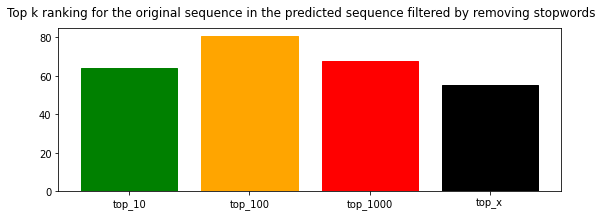

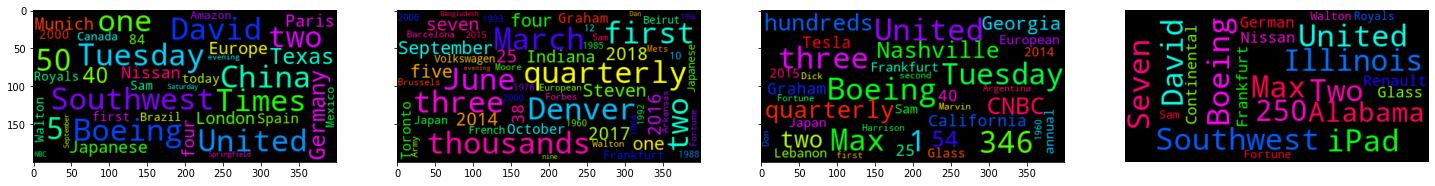

In [71]:
#analyse_text([article[i]['sentenceSplit'] for i in dataset['train'].shape[0]])
#analyse_text([dataset['train'][i]['sentenceSplit'] for i in range(5)])

from src.insights import topk_insight

topk_insight.analyse_text([dataset['train'][i]['sentenceSplit'] for i in range(5)])

In [55]:
from typing import List

def analyse_text(articles: List):
    #from nltk.corpus import stopwords

    ################
    #import nltk
    #nltk.download('stopwords')
    ###############

    # curated stop_words
    import spacy

    nlp = spacy.load("en_core_web_sm")


    top_10_cnt = 0
    top_100_cnt = 0
    top_1000_cnt = 0
    top_x_cnt = 0

    word_dict_10 = {}
    word_dict_100 = {}
    word_dict_1000 = {}
    word_dict_x = {}

    for article in articles:
        article_list = article.split("\n")
        
        doc = nlp(article)
        ent_list = [ent.text for ent in doc.ents]
        
        for sentence in article_list:
            if len(sentence.split(" "))>5:
                text = gpt.tokenizer.bos_token + " " + sentence
                outputs = gpt.get_probabilities(text, top_k=1000)
                for idx, (rank, probs) in enumerate(outputs['true_topk']):
                    if outputs['bpe_strings'][idx+1] in ent_list:
                        #print(outputs['bpe_strings'][idx+1])
                        if rank<=10:
                            top_10_cnt += 1
                            word_dict_10[outputs['bpe_strings'][idx+1]] = 100
                            #print(outputs['bpe_strings'][idx+1], outputs['pred_topk'][idx][rank])
                        elif rank<=100:
                            top_100_cnt += 1
                            word_dict_100[outputs['bpe_strings'][idx+1]] = 100
                        elif rank<=1000:
                            top_1000_cnt += 1
                            word_dict_1000[outputs['bpe_strings'][idx+1]] = 100
                        else:
                            top_x_cnt += 1
                            word_dict_x[outputs['bpe_strings'][idx+1]] = 100
    
    import matplotlib.pyplot as plt

    data = {'top_10': top_10_cnt, 'top_100': top_100_cnt, 'top_1000': top_1000_cnt, 'top_x': top_x_cnt}
    names = list(data.keys())
    values = list(data.values())

    fig, axs = plt.subplots(1, 1, figsize=(9, 3), sharey=True)
    bar = axs.bar(names, values)
    bar[0].set_color('green')
    bar[1].set_color('orange')
    bar[2].set_color('red')
    bar[3].set_color('black')
    fig.suptitle('Top k ranking for the original sequence in the predicted sequence filtered by removing stopwords')
    
    from wordcloud import WordCloud

    cloud10 = WordCloud(max_font_size=40,colormap="hsv").generate_from_frequencies(word_dict_10)
    cloud100 = WordCloud(max_font_size=40,colormap="hsv").generate_from_frequencies(word_dict_100)
    cloud1000 = WordCloud(max_font_size=40,colormap="hsv").generate_from_frequencies(word_dict_1000)
    cloudx = WordCloud(max_font_size=40,colormap="hsv").generate_from_frequencies(word_dict_x)
    fig, axs = plt.subplots(1, 4, figsize=(25,20), sharey=True)
    #plt.figure(figsize=(16,12))
    axs[0].imshow(cloud10, interpolation='bilinear')
    axs[1].imshow(cloud100, interpolation='bilinear')
    axs[2].imshow(cloud1000, interpolation='bilinear')
    axs[3].imshow(cloudx, interpolation='bilinear')

    plt.axis('off')
    plt.show()

In [24]:
top_10_cnt = 0
top_100_cnt = 0
top_1000_cnt = 0
top_x_cnt = 0

for sentence in article_list:
    text = gpt.tokenizer.bos_token + " " + sentence
    outputs = gpt.get_probabilities(text, top_k=1000)
    for rank, probs in outputs['true_topk']:
        if rank<=10:
            top_10_cnt += 1
        elif rank<=100:
            top_100_cnt += 1
        elif rank<=1000:
            top_1000_cnt += 1
        else:
            top_x_cnt += 1

In [25]:
print (top_10_cnt, top_100_cnt, top_1000_cnt, top_x_cnt)

680 198 130 80


Text(0.5, 0.98, 'Top k ranking for the original sequence in the predicted sequence filtered by removing stopwords')

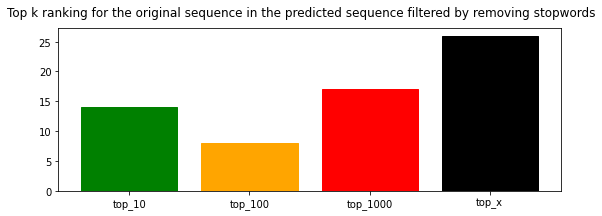

In [49]:
import matplotlib.pyplot as plt

data = {'top_10': top_10_cnt, 'top_100': top_100_cnt, 'top_1000': top_1000_cnt, 'top_x': top_x_cnt}
names = list(data.keys())
values = list(data.values())

fig, axs = plt.subplots(1, 1, figsize=(9, 3), sharey=True)
bar = axs.bar(names, values)
bar[0].set_color('green')
bar[1].set_color('orange')
bar[2].set_color('red')
bar[3].set_color('black')
fig.suptitle('Top k ranking for the original sequence in the predicted sequence filtered by removing stopwords')

In [31]:
#from nltk.corpus import stopwords

################
#import nltk
#nltk.download('stopwords')
###############

# curated stop_words
import string

with open("../data/stopwords-en.txt") as f:
    content = f.readlines()
stop_words = set([x.strip() for x in content] + list(string.punctuation)) 


top_10_cnt = 0
top_100_cnt = 0
top_1000_cnt = 0
top_x_cnt = 0

word_dict_10 = {}
word_dict_100 = {}
word_dict_1000 = {}
word_dict_x = {}

for sentence in article_list:
    if len(sentence.split(" "))>5:
        text = gpt.tokenizer.bos_token + " " + sentence
        outputs = gpt.get_probabilities(text, top_k=1000)
        for idx, (rank, probs) in enumerate(outputs['true_topk']):
            if outputs['bpe_strings'][idx+1] not in stop_words:
                #print(outputs['bpe_strings'][idx+1])
                if rank<=10:
                    top_10_cnt += 1
                    word_dict_10[outputs['bpe_strings'][idx+1]] = 100
                    #print(outputs['bpe_strings'][idx+1], outputs['pred_topk'][idx][rank])
                elif rank<=100:
                    top_100_cnt += 1
                    word_dict_100[outputs['bpe_strings'][idx+1]] = 100
                elif rank<=1000:
                    top_1000_cnt += 1
                    word_dict_1000[outputs['bpe_strings'][idx+1]] = 100
                else:
                    top_x_cnt += 1
                    word_dict_x[outputs['bpe_strings'][idx+1]] = 100

Text(0.5, 0.98, 'Top k ranking for the original sequence in the predicted sequence filtered by removing stopwords')

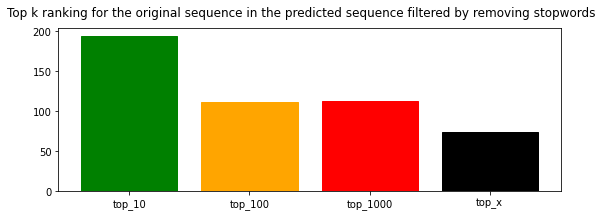

In [26]:
import matplotlib.pyplot as plt

data = {'top_10': top_10_cnt, 'top_100': top_100_cnt, 'top_1000': top_1000_cnt, 'top_x': top_x_cnt}
names = list(data.keys())
values = list(data.values())

fig, axs = plt.subplots(1, 1, figsize=(9, 3), sharey=True)
bar = axs.bar(names, values)
bar[0].set_color('green')
bar[1].set_color('orange')
bar[2].set_color('red')
bar[3].set_color('black')
fig.suptitle('Top k ranking for the original sequence in the predicted sequence filtered by removing stopwords')

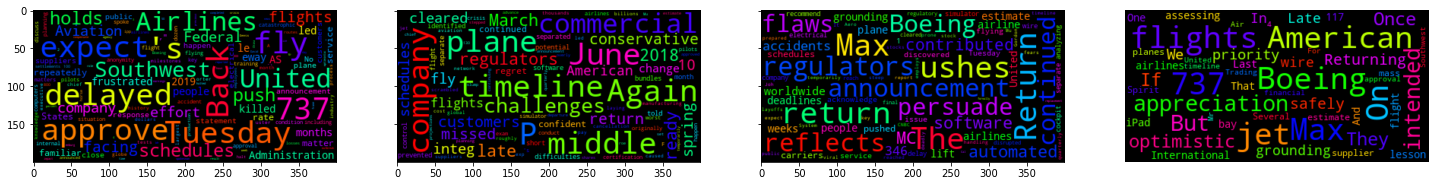

In [44]:
from wordcloud import WordCloud

cloud10 = WordCloud(max_font_size=40,colormap="hsv").generate_from_frequencies(word_dict_10)
cloud100 = WordCloud(max_font_size=40,colormap="hsv").generate_from_frequencies(word_dict_100)
cloud1000 = WordCloud(max_font_size=40,colormap="hsv").generate_from_frequencies(word_dict_1000)
cloudx = WordCloud(max_font_size=40,colormap="hsv").generate_from_frequencies(word_dict_x)
fig, axs = plt.subplots(1, 4, figsize=(25,20), sharey=True)
#plt.figure(figsize=(16,12))
axs[0].imshow(cloud10, interpolation='bilinear')
axs[1].imshow(cloud100, interpolation='bilinear')
axs[2].imshow(cloud1000, interpolation='bilinear')
axs[3].imshow(cloudx, interpolation='bilinear')

plt.axis('off')
plt.show()

In [7]:
from src.insights import topk_insight
#from nltk.corpus import stopwords

################
#import nltk
#nltk.download('stopwords')
###############

# curated stop_words
import spacy

nlp = spacy.load("en_core_web_sm")


top_10_cnt = 0
top_100_cnt = 0
top_1000_cnt = 0
top_x_cnt = 0

word_dict_10 = {}
word_dict_100 = {}
word_dict_1000 = {}
word_dict_x = {}

doc = nlp(raw_text)
ent_list = [ent.text for ent in doc.ents]

#for sentence in article_list:
for sentence in [raw_text]:
    sen = ""
    for s in sentence.split(' '):
        if len((s + sen).split(' '))<800:
            sen = sen + " " + s
    sentence = sen[1:]
    if len(sentence.split(" "))>5:
        text = gpt.tokenizer.bos_token + " " + sentence
        outputs = gpt.get_probabilities(text, top_k=1000)
        for idx, (rank, probs) in enumerate(outputs['true_topk']):
            if outputs['bpe_strings'][idx+1] in ent_list:
                #print(outputs['bpe_strings'][idx+1])
                if rank<=10:
                    top_10_cnt += 1
                    word_dict_10[outputs['bpe_strings'][idx+1]] = 100
                    #print(outputs['bpe_strings'][idx+1], outputs['pred_topk'][idx][rank])
                elif rank<=100:
                    top_100_cnt += 1
                    word_dict_100[outputs['bpe_strings'][idx+1]] = 100
                elif rank<=1000:
                    top_1000_cnt += 1
                    word_dict_1000[outputs['bpe_strings'][idx+1]] = 100
                else:
                    top_x_cnt += 1
                    word_dict_x[outputs['bpe_strings'][idx+1]] = 100

Text(0.5, 0.98, 'Top k ranking for the original sequence in the predicted sequence filtered by removing stopwords')

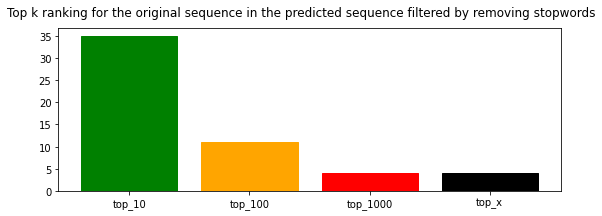

In [8]:
import matplotlib.pyplot as plt

data = {'top_10': top_10_cnt, 'top_100': top_100_cnt, 'top_1000': top_1000_cnt, 'top_x': top_x_cnt}
names = list(data.keys())
values = list(data.values())

fig, axs = plt.subplots(1, 1, figsize=(9, 3), sharey=True)
bar = axs.bar(names, values)
bar[0].set_color('green')
bar[1].set_color('orange')
bar[2].set_color('red')
bar[3].set_color('black')
fig.suptitle('Top k ranking for the original sequence in the predicted sequence filtered by removing stopwords')

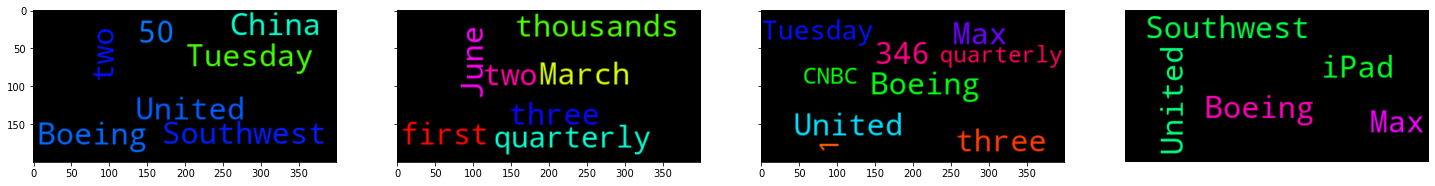

In [65]:
from wordcloud import WordCloud

cloud10 = WordCloud(max_font_size=40,colormap="hsv").generate_from_frequencies(word_dict_10)
cloud100 = WordCloud(max_font_size=40,colormap="hsv").generate_from_frequencies(word_dict_100)
cloud1000 = WordCloud(max_font_size=40,colormap="hsv").generate_from_frequencies(word_dict_1000)
cloudx = WordCloud(max_font_size=40,colormap="hsv").generate_from_frequencies(word_dict_x)
fig, axs = plt.subplots(1, 4, figsize=(25,20), sharey=True)
#plt.figure(figsize=(16,12))
axs[0].imshow(cloud10, interpolation='bilinear')
axs[1].imshow(cloud100, interpolation='bilinear')
axs[2].imshow(cloud1000, interpolation='bilinear')
axs[3].imshow(cloudx, interpolation='bilinear')

plt.axis('off')
plt.show()

In [76]:
print(len(outputs['pred_topk']), len(outputs['true_topk']))

22 22


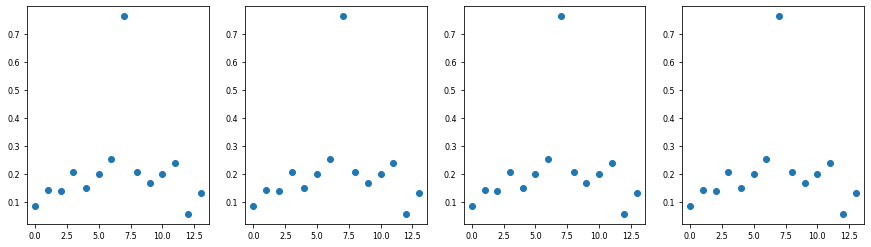

In [164]:
import numpy as np
import matplotlib.pyplot as plt

def scatter_plot(probs):
    x = list(range(len(probs)))
    y = probs
    
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.005


    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]

    # start with a square Figure
    #fig = plt.figure(figsize=(4, 4))
    fig, axs = plt.subplots(1, 4, figsize=(15, 4))
    
    #ax = fig.add_axes(rect_scatter)
    #ax_histx = fig.add_axes(rect_histx, sharex=ax)
    #ax_histy = fig.add_axes(rect_histy, sharey=ax)

    #ax_histx.tick_params(axis="x", labelbottom=False)
    #ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    axs[0].scatter(x, y)
    axs[1].scatter(x, y)
    axs[2].scatter(x, y)
    axs[3].scatter(x, y)

    #ax_histx.hist(x)
    #ax_histy.hist(y, orientation='horizontal')
    

    plt.show()
    
scatter_plot(probs_10)

In [126]:
#from nltk.corpus import stopwords

################
#import nltk
#nltk.download('stopwords')
###############

# curated stop_words
import spacy

nlp = spacy.load("en_core_web_sm")

top_10_cnt, word_dict_10, probs_10 = 0, {}, []
top_100_cnt, word_dict_100, probs_100 = 0, {}, []
top_1000_cnt, word_dict_1000, probs_1000 = 0, {}, []
top_x_cnt, word_dict_x, probs_x = 0, {}, []

doc = nlp(raw_text)
ent_list = [ent.text for ent in doc.ents]

for sentence in article_list:
    if len(sentence.split(" "))>5:
        text = gpt.tokenizer.bos_token + " " + sentence
        outputs = gpt.get_probabilities(text, top_k=1000)
        for idx, (rank, probs) in enumerate(outputs['true_topk']):
            if outputs['bpe_strings'][idx+1] in ent_list:
                #print(outputs['bpe_strings'][idx+1], outputs['pred_topk'][idx][0][1])
                if rank<=10:
                    top_10_cnt += 1
                    word_dict_10[outputs['bpe_strings'][idx+1]] = 100
                    probs_10.append(outputs['pred_topk'][idx][0][1])
                    #print(outputs['bpe_strings'][idx+1], outputs['pred_topk'][idx][rank])
                elif rank<=100:
                    top_100_cnt += 1
                    word_dict_100[outputs['bpe_strings'][idx+1]] = 100
                    probs_100.append(outputs['pred_topk'][idx][0][1])
                elif rank<=1000:
                    top_1000_cnt += 1
                    word_dict_1000[outputs['bpe_strings'][idx+1]] = 100
                    probs_1000.append(outputs['pred_topk'][idx][0][1])
                else:
                    top_x_cnt += 1
                    word_dict_x[outputs['bpe_strings'][idx+1]] = 100
                    #print(outputs['true_topk'][idx])
                    probs_x.append(outputs['pred_topk'][idx][0][1])

In [127]:
probs_x

[0.0623,
 0.17308,
 0.11608,
 0.12457,
 0.0623,
 0.03981,
 0.04728,
 0.10446,
 0.27672,
 0.01043,
 0.19621,
 0.0623,
 0.04586,
 0.15203,
 0.0623,
 0.06895,
 0.01473,
 0.19018,
 0.0623,
 0.0623,
 0.08857,
 0.0623,
 0.24742,
 0.33101,
 0.0623,
 0.03454]

In [170]:
str([token for token in doc if token.tag_[:2]=="NN"][0])

'Boeing'